<a href="https://colab.research.google.com/github/evanalif113/CAPSTONE-PROJECT-IOT/blob/main/Model-Deep-Learning/Kumbung_LSTM_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Impor Pustaka
Sel ini mengimpor semua pustaka yang diperlukan untuk analisis data, visualisasi, dan pemodelan, termasuk `pandas` untuk manipulasi data, `matplotlib` dan `seaborn` untuk visualisasi, serta `firebase_admin` untuk interaksi dengan Firebase Realtime Database.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation
import datetime
import seaborn as sns
import missingno as msno
import firebase_admin
from firebase_admin import credentials, db
from datetime import datetime  # Untuk konversi timestamp ke human-readable
sns.set_theme(style="whitegrid")
%matplotlib inline

In [6]:
# Konfigurasi database sumber
source_cred = credentials.Certificate("/content/kunci_firebase.json")
firebase_admin.initialize_app(source_cred, {
    'databaseURL': 'https://kumbung-sense-default-rtdb.asia-southeast1.firebasedatabase.app/'
})

In [7]:
# Input readable date
start_readable_date = "01-06-2025 00:00:00"  # Format: DD-MM-YYYY HH:MM:SS
end_readable_date = "30-07-2025 23:59:59"  # Format: DD-MM-YYYY HH:MM:SS

# Convert readable date to Unix timestamp
start_timestamp = int(datetime.strptime(start_readable_date, "%d-%m-%Y %H:%M:%S").timestamp())
print(start_timestamp) # Convert to string and print
end_timestamp = int(datetime.strptime(end_readable_date, "%d-%m-%Y %H:%M:%S").timestamp())
print(end_timestamp) # Convert to string and print


1748736000
1753919999


In [8]:
# Refer ke path data
ref_data = db.reference('/GQAUD4ySfaNncpiZEkiKYNITWvK2/sensor/data')

# Ambil data yang key-nya berada dalam rentang waktu yang ditentukan
query_data = ref_data.order_by_key().start_at(str(start_timestamp)).end_at(str(end_timestamp))

# Ambil hasil
results_data = query_data.get()


In [9]:
# Mengubah data menjadi DataFrame pandas untuk data pertama
if results_data:
    kumbung = pd.DataFrame.from_dict(results_data, orient='index')

    # Jika 'timestamp' sudah ada, jangan pindahkan indeks ke kolom
    if 'timestamp' not in kumbung.columns:
        kumbung.index.name = 'timestamp'  # Mengatur nama indeks
        kumbung.reset_index(inplace=True)  # Memindahkan indeks menjadi kolom biasa

    print("Data dari sumber pertama:")
    print(kumbung.head())  # Menampilkan data untuk verifikasi
else:
    print("Tidak ada data dari sumber pertama")

Data dari sumber pertama:
            humidity  light  moisture  temperature   timestamp
1751843642     89.64    0.0     100.0        28.06  1751843642
1751843672     89.63    0.0     100.0        28.04  1751843672
1751843702     89.62    0.0     100.0        28.04  1751843702
1751843732     89.65    0.0     100.0        28.06  1751843732
1751843762     89.66    0.0     100.0        28.06  1751843762


In [10]:
kumbung.tail(10)

,humidity,light,moisture,temperature,timestamp
1752756985,86.13,0.0,100.00000,28.92,1752756985
1752757015,86.12,0.0,100.00000,28.91,1752757015
1752757045,86.15,0.0,100.00000,28.91,1752757045
1752757075,86.13,0.0,100.00000,28.92,1752757075
1752757105,86.10,0.0,100.00000,28.92,1752757105
1752757135,86.13,0.0,100.00000,28.92,1752757135
1752757165,86.11,0.0,98.58364,28.92,1752757165
1752757195,86.53,0.0,100.00000,28.90,1752757195
1752757225,86.60,0.0,100.00000,28.90,1752757225
1752757255,86.56,0.0,100.00000,28.92,1752757255


In [11]:
kumbung['timestamp']= kumbung['timestamp'].astype(int)
kumbung.tail(10)

,humidity,light,moisture,temperature,timestamp
1752756985,86.13,0.0,100.00000,28.92,1752756985
1752757015,86.12,0.0,100.00000,28.91,1752757015
1752757045,86.15,0.0,100.00000,28.91,1752757045
1752757075,86.13,0.0,100.00000,28.92,1752757075
1752757105,86.10,0.0,100.00000,28.92,1752757105
1752757135,86.13,0.0,100.00000,28.92,1752757135
1752757165,86.11,0.0,98.58364,28.92,1752757165
1752757195,86.53,0.0,100.00000,28.90,1752757195
1752757225,86.60,0.0,100.00000,28.90,1752757225
1752757255,86.56,0.0,100.00000,28.92,1752757255


In [12]:
# Konversi timestamp ke datetime dalam format UTC
kumbung['timestamp'] = pd.to_datetime(kumbung['timestamp'], unit='s', utc=True)

# Mengonversi ke zona waktu WIB (Asia/Jakarta)
kumbung['timestamp'] = kumbung['timestamp'].dt.tz_convert('Asia/Jakarta')

In [13]:
kumbung.dtypes

,0
humidity,float64
light,float64
moisture,float64
temperature,float64
timestamp,"datetime64[ns, Asia/Jakarta]"


In [14]:
kumbung.head(10)

,humidity,light,moisture,temperature,timestamp
1751843642,89.64,0.0,100.0,28.06,2025-07-07 06:14:02+07:00
1751843672,89.63,0.0,100.0,28.04,2025-07-07 06:14:32+07:00
1751843702,89.62,0.0,100.0,28.04,2025-07-07 06:15:02+07:00
1751843732,89.65,0.0,100.0,28.06,2025-07-07 06:15:32+07:00
1751843762,89.66,0.0,100.0,28.06,2025-07-07 06:16:02+07:00
1751843792,89.67,0.0,100.0,28.03,2025-07-07 06:16:32+07:00
1751843822,89.69,0.0,100.0,28.06,2025-07-07 06:17:02+07:00
1751843852,89.69,0.0,100.0,28.06,2025-07-07 06:17:32+07:00
1751844249,89.77,0.0,100.0,28.09,2025-07-07 06:24:09+07:00
1751844279,89.76,0.0,100.0,28.07,2025-07-07 06:24:39+07:00


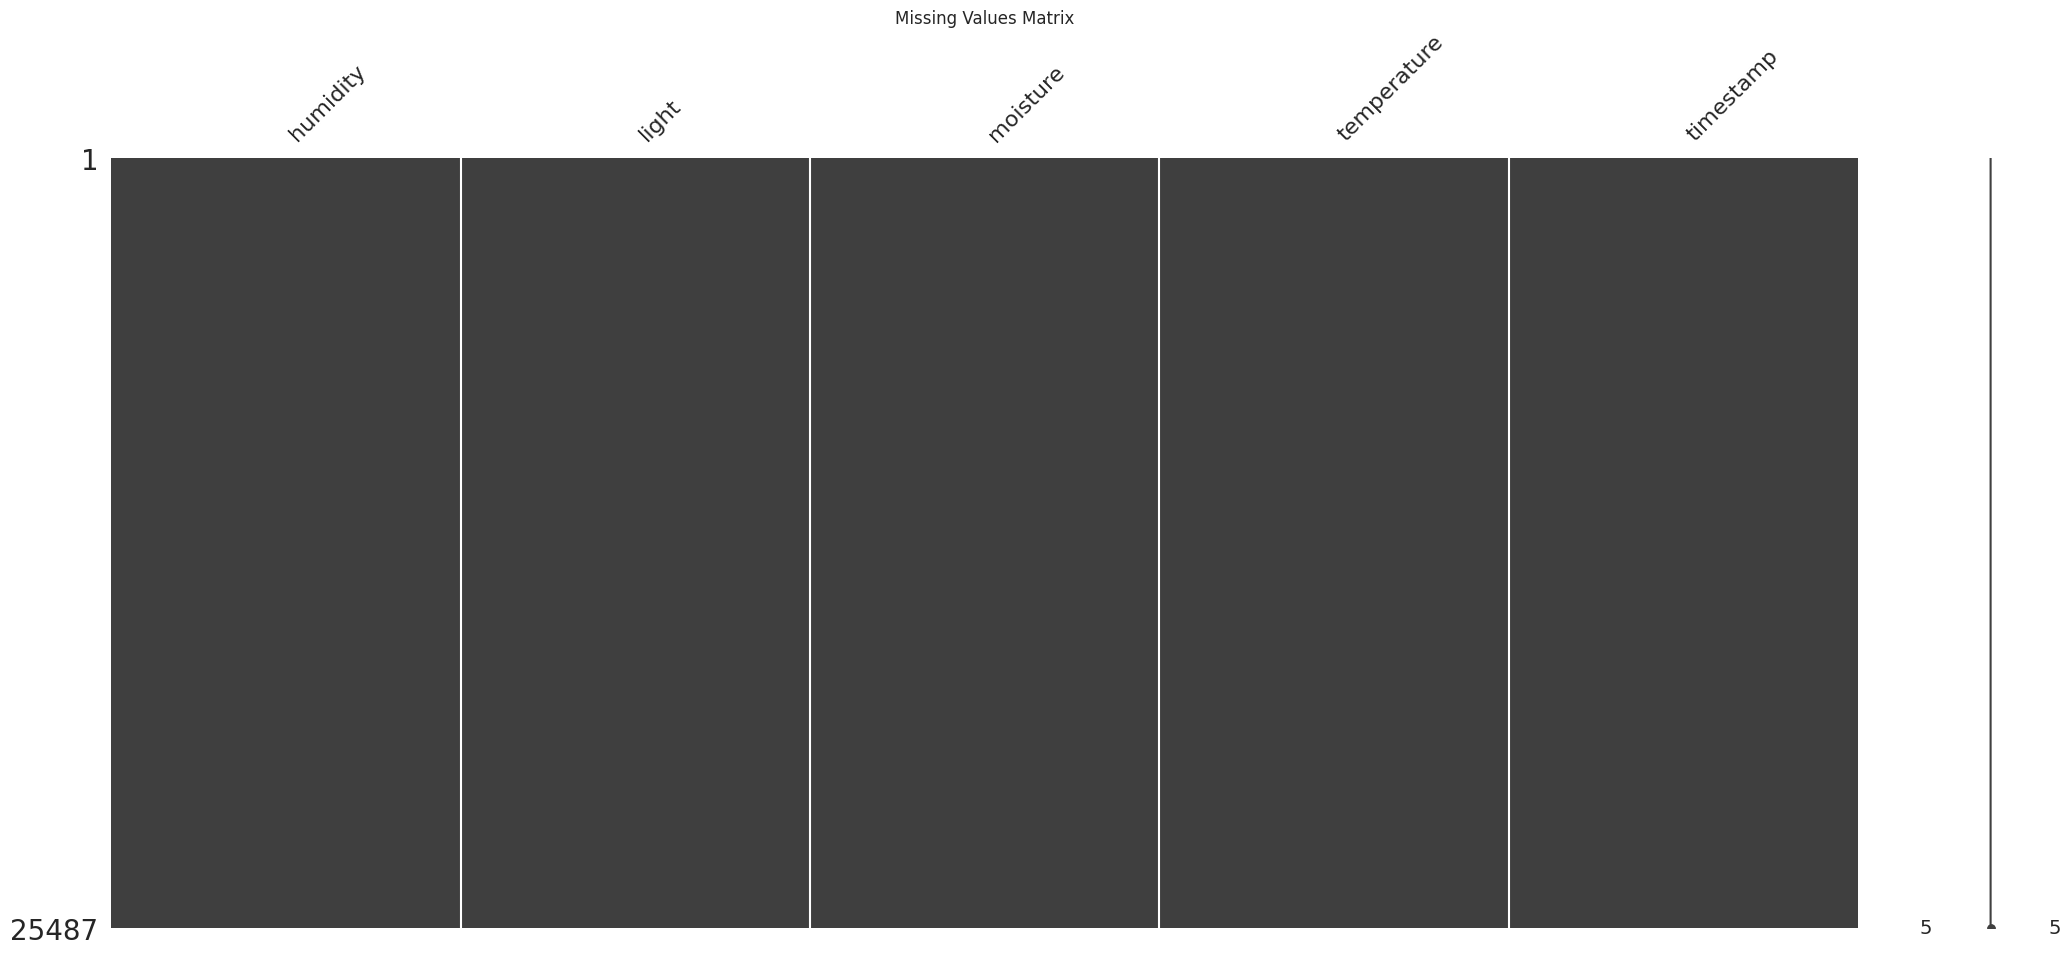

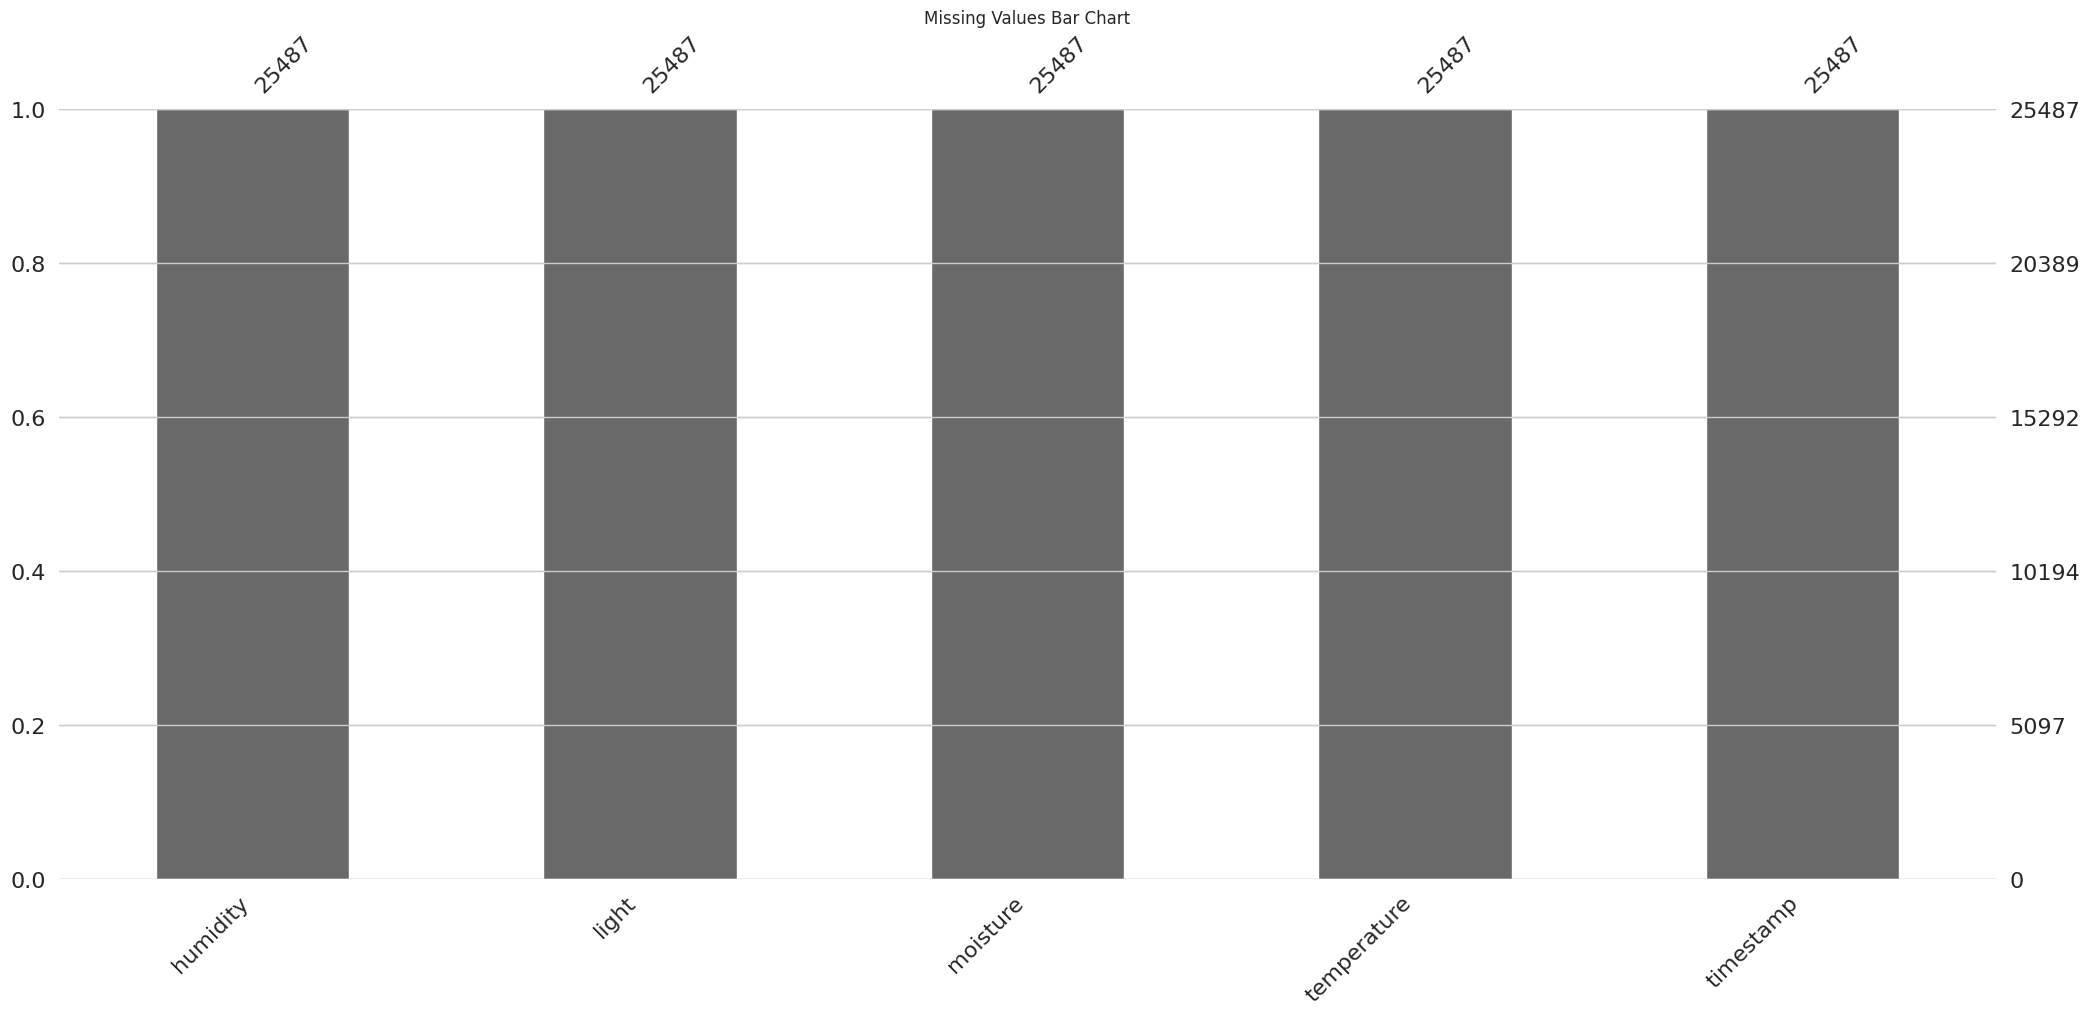

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


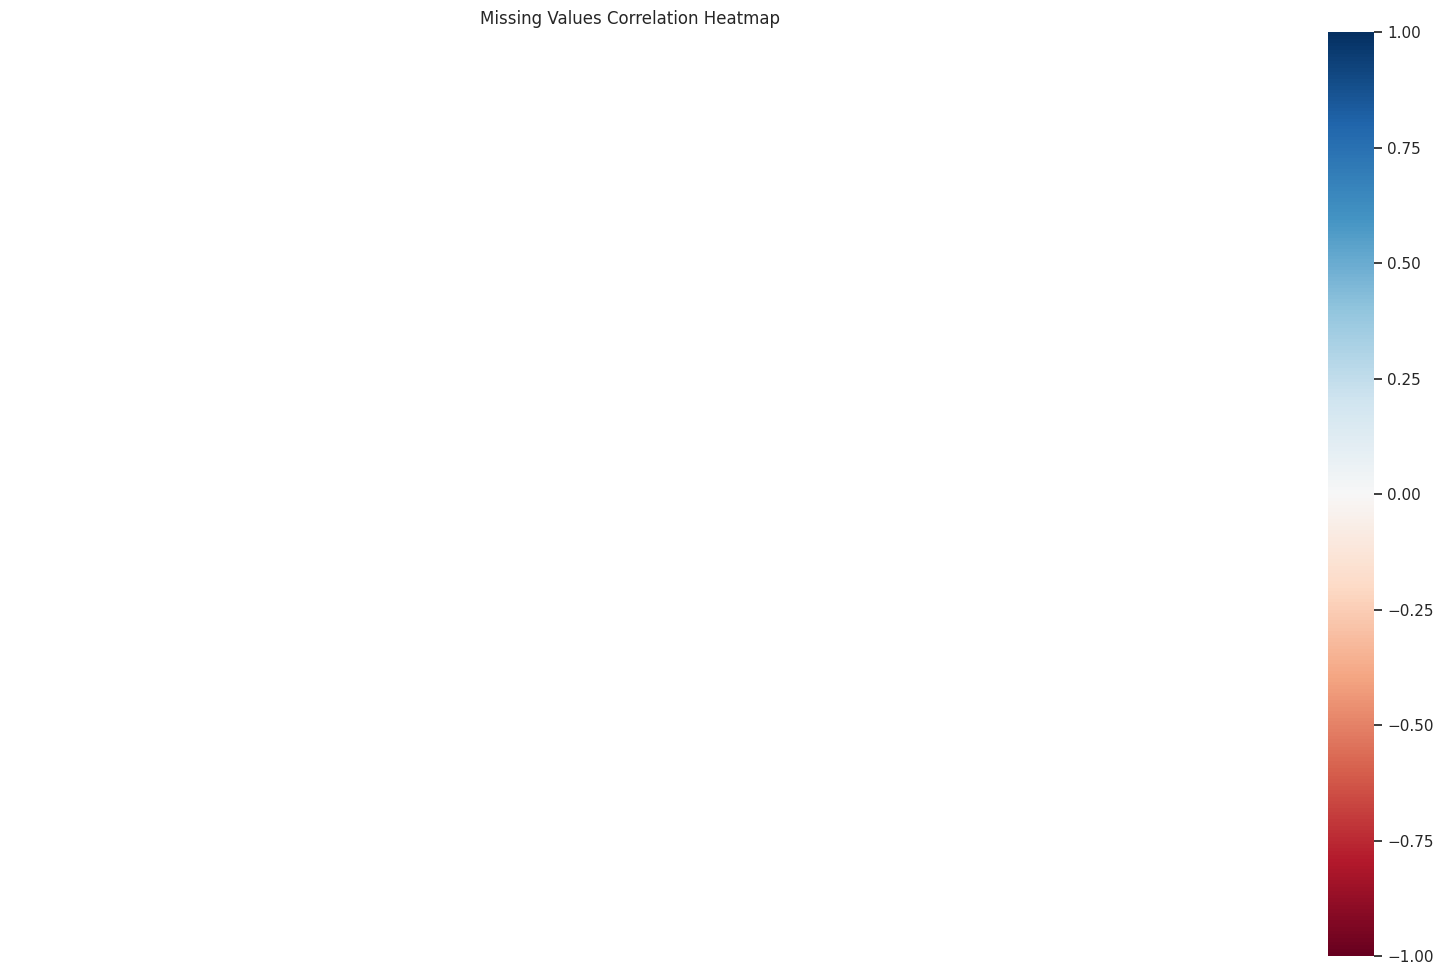

humidity       0
light          0
moisture       0
temperature    0
timestamp      0
dtype: int64


In [15]:
# Visualisasi missing values untuk kumbung
msno.matrix(kumbung)
plt.title("Missing Values Matrix")
plt.show()

msno.bar(kumbung)
plt.title("Missing Values Bar Chart")
plt.show()

msno.heatmap(kumbung)
plt.title("Missing Values Correlation Heatmap")
plt.show()

# Menampilkan ringkasan missing values
print(kumbung.isnull().sum())

### Visualisasi Outlier Sebelum Dibersihkan
Sebelum membersihkan outlier, mari kita visualisasikan data untuk melihat distribusinya dan mengidentifikasi adanya outlier menggunakan boxplot.

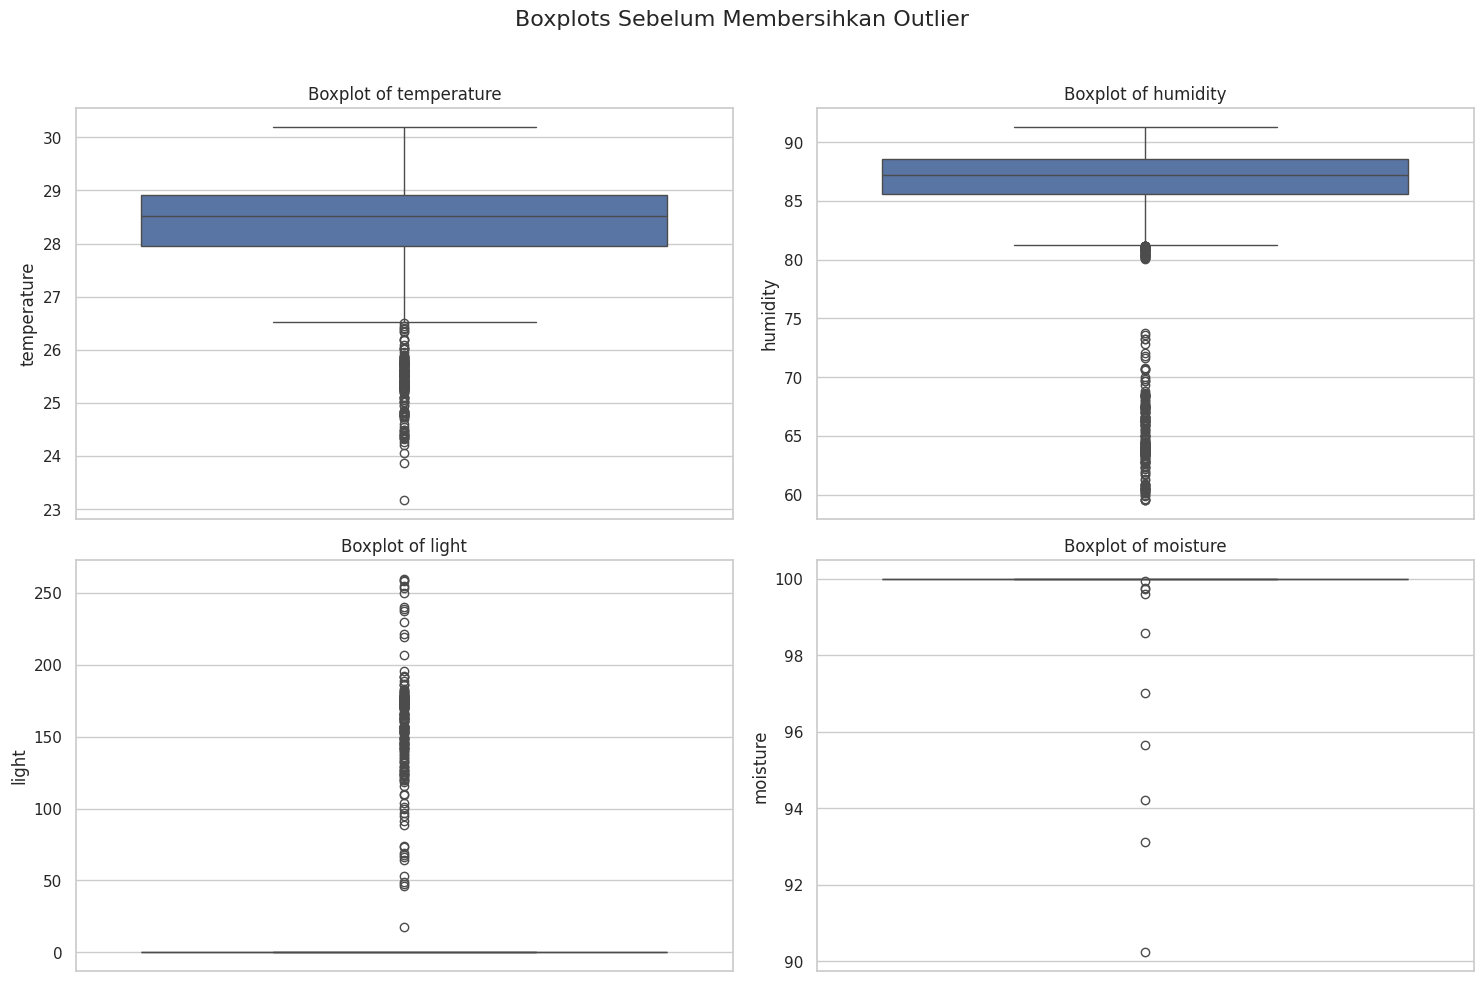

In [16]:
# Visualisasi data sebelum membersihkan outlier dengan boxplot
columns_to_visualize = ['temperature', 'humidity', 'light', 'moisture']
plt.figure(figsize=(15, 10))
plt.suptitle("Boxplots Sebelum Membersihkan Outlier", fontsize=16)
for i, col in enumerate(columns_to_visualize):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(y=kumbung[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Membersihkan Outlier
Selanjutnya, kita akan membersihkan data dari outlier. Outlier adalah data yang nilainya sangat berbeda dari sebagian besar data lainnya. Kita akan menggunakan metode IQR (Interquartile Range) untuk mendeteksi dan mengganti outlier dengan nilai median dari masing-masing kolom.

Jumlah outlier di kolom 'temperature': 193
Outlier di kolom 'temperature' telah diganti dengan median.
Jumlah outlier di kolom 'humidity': 250
Outlier di kolom 'humidity' telah diganti dengan median.
Jumlah outlier di kolom 'light': 197
Outlier di kolom 'light' telah diganti dengan median.
Jumlah outlier di kolom 'moisture': 10
Outlier di kolom 'moisture' telah diganti dengan median.

Data setelah membersihkan outlier:
           humidity    light  moisture   temperature
count  25487.000000  25487.0   25487.0  25487.000000
mean      87.060306      0.0     100.0     28.442137
std        1.965523      0.0       0.0      0.642026
min       81.220000      0.0     100.0     26.530000
25%       85.670000      0.0     100.0     27.990000
50%       87.250000      0.0     100.0     28.510000
75%       88.560000      0.0     100.0     28.920000
max       91.330000      0.0     100.0     30.200000


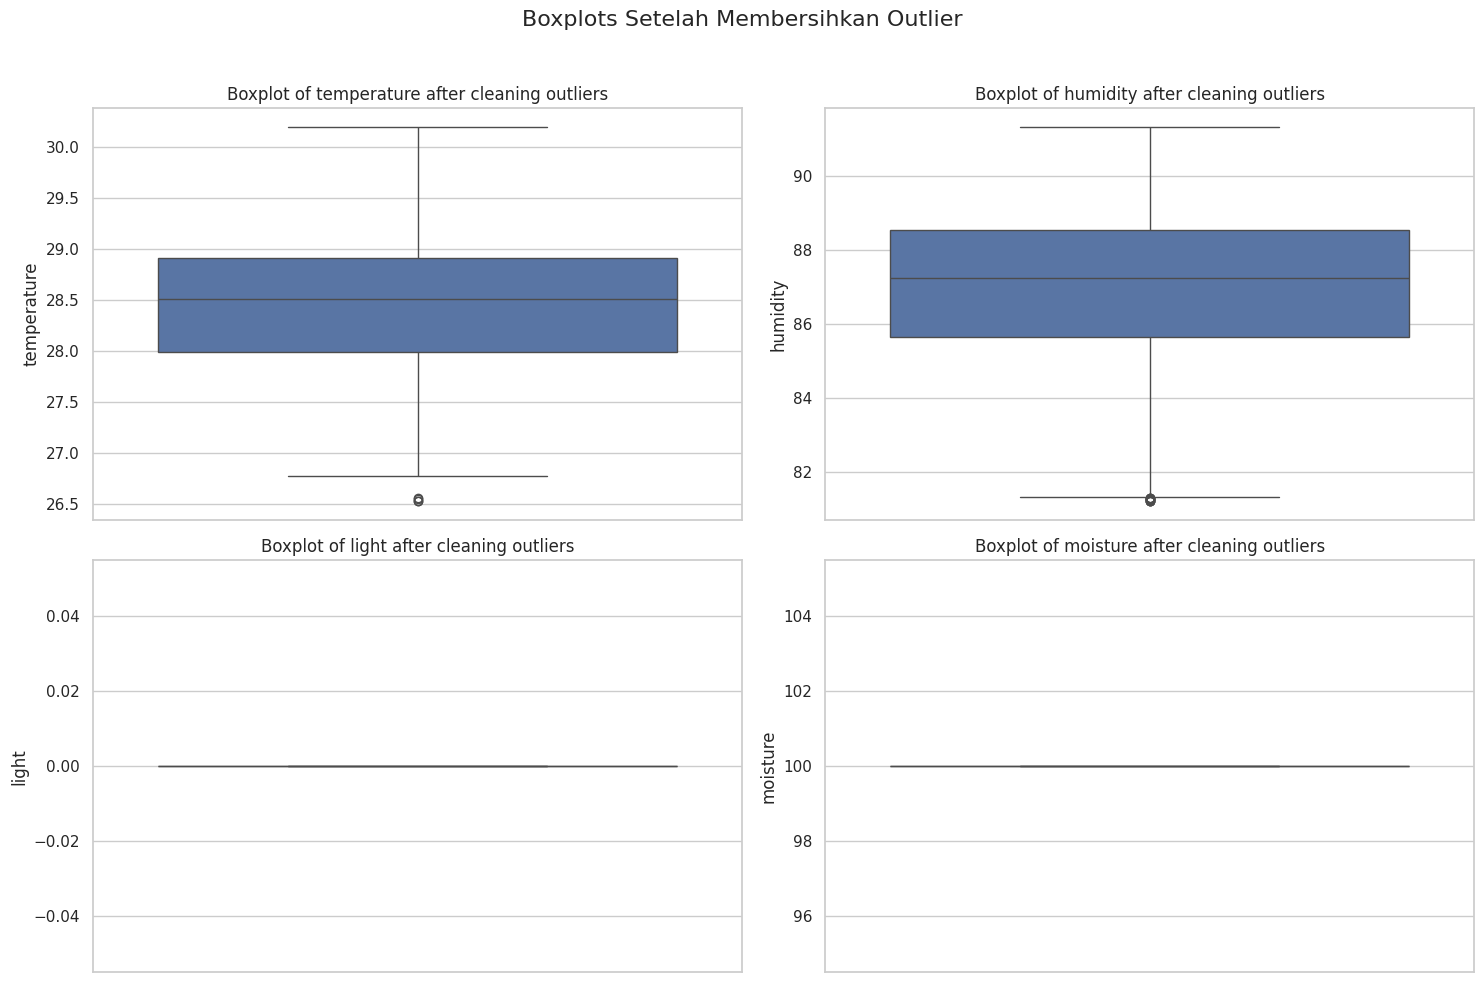

In [17]:
# Fungsi untuk membersihkan outlier menggunakan metode IQR
def clean_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Hitung jumlah outlier
    outliers_count = df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]
    print(f"Jumlah outlier di kolom '{column}': {outliers_count}")

    # Ganti outlier dengan median
    if outliers_count > 0:
        median_val = df[column].median()
        df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = median_val
        print(f"Outlier di kolom '{column}' telah diganti dengan median.")
    else:
        print(f"Tidak ada outlier yang ditemukan di kolom '{column}'.")

    return df

# Kolom yang akan dibersihkan dari outlier
columns_to_clean = ['temperature', 'humidity', 'light', 'moisture']

# Membersihkan outlier untuk setiap kolom
for col in columns_to_clean:
    kumbung = clean_outliers_iqr(kumbung, col)

print("\nData setelah membersihkan outlier:")
print(kumbung.describe())

# Visualisasi data setelah membersihkan outlier dengan boxplot
plt.figure(figsize=(15, 10))
plt.suptitle("Boxplots Setelah Membersihkan Outlier", fontsize=16)
for i, col in enumerate(columns_to_clean):
	plt.subplot(2, 2, i + 1)
	sns.boxplot(y=kumbung[col])
	plt.title(f'Boxplot of {col} after cleaning outliers')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

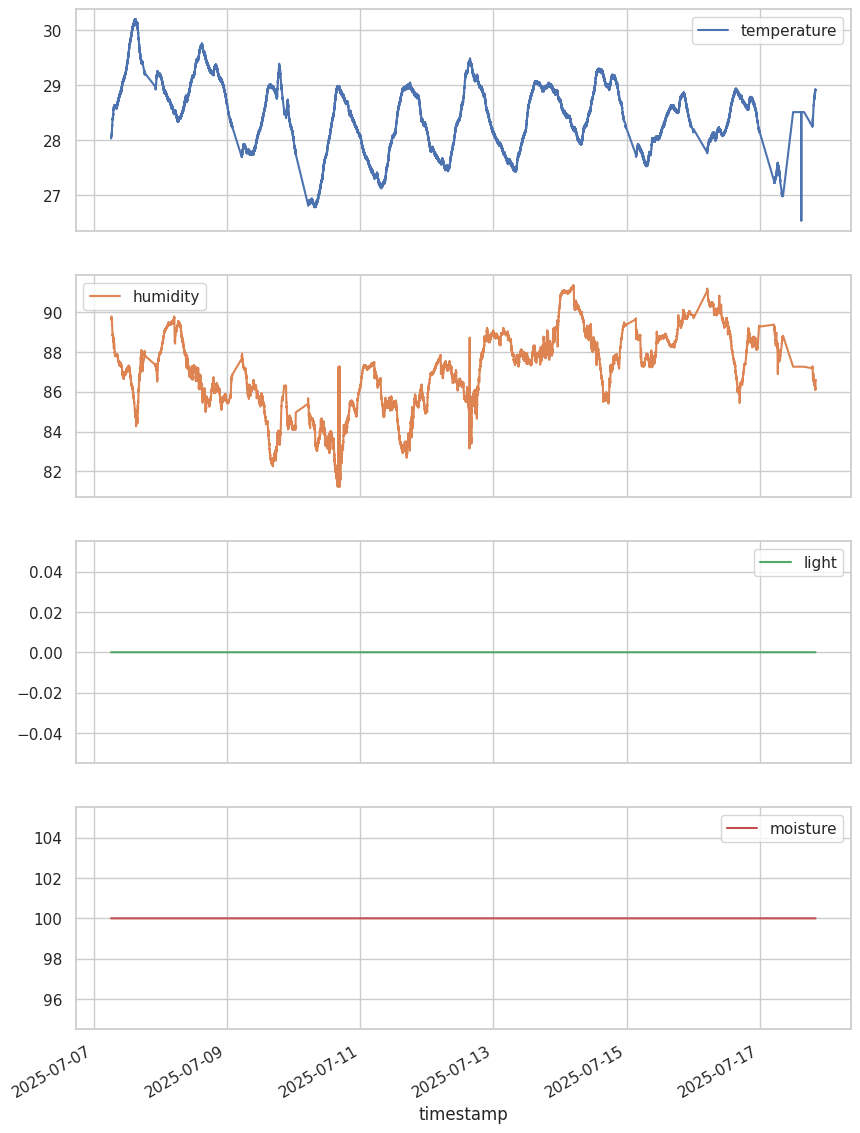

In [18]:
kumbung.plot(
    y=[
    'temperature',
    'humidity',
    'light',
    'moisture'
    ],
    x='timestamp',
    subplots=True, figsize=(10, 15))
plt.show()

In [41]:
# Ekspor kumbung2 ke CSV dengan delimiter titik koma (;)
kumbung.to_csv('kumbung.csv', sep=',', index=False)

In [42]:
# prompt: buatlah kode untuk membuat dataframe dengan nama kumbung dari membaca file kumbung.csv

import pandas as pd
kumbung = pd.read_csv('kumbung.csv')

In [43]:
kumbung.tail(10)

,humidity,light,moisture,temperature,timestamp,hour,minute,day,week,month,year
25477,86.13,0.0,100.0,28.92,2025-07-17 19:56:25+07:00,2025-07-17 19:00:00+07:00,56,2025-07-17 00:00:00+07:00,29,7,2025
25478,86.12,0.0,100.0,28.91,2025-07-17 19:56:55+07:00,2025-07-17 19:00:00+07:00,56,2025-07-17 00:00:00+07:00,29,7,2025
25479,86.15,0.0,100.0,28.91,2025-07-17 19:57:25+07:00,2025-07-17 19:00:00+07:00,57,2025-07-17 00:00:00+07:00,29,7,2025
25480,86.13,0.0,100.0,28.92,2025-07-17 19:57:55+07:00,2025-07-17 19:00:00+07:00,57,2025-07-17 00:00:00+07:00,29,7,2025
25481,86.10,0.0,100.0,28.92,2025-07-17 19:58:25+07:00,2025-07-17 19:00:00+07:00,58,2025-07-17 00:00:00+07:00,29,7,2025
25482,86.13,0.0,100.0,28.92,2025-07-17 19:58:55+07:00,2025-07-17 19:00:00+07:00,58,2025-07-17 00:00:00+07:00,29,7,2025
25483,86.11,0.0,100.0,28.92,2025-07-17 19:59:25+07:00,2025-07-17 19:00:00+07:00,59,2025-07-17 00:00:00+07:00,29,7,2025
25484,86.53,0.0,100.0,28.90,2025-07-17 19:59:55+07:00,2025-07-17 19:00:00+07:00,59,2025-07-17 00:00:00+07:00,29,7,2025
25485,86.60,0.0,100.0,28.90,2025-07-17 20:00:25+07:00,2025-07-17 20:00:00+07:00,0,2025-07-17 00:00:00+07:00,29,7,2025
25486,86.56,0.0,100.0,28.92,2025-07-17 20:00:55+07:00,2025-07-17 20:00:00+07:00,0,2025-07-17 00:00:00+07:00,29,7,2025


In [22]:
# Mengubah kolom 'timestamp' menjadi datetime
kumbung['timestamp'] = pd.to_datetime(kumbung['timestamp'])

# Mengurutkan data berdasarkan 'timestamp'
kumbung = kumbung.sort_values(by='timestamp')

# Menambahkan kolom 'hour', 'minute', 'day', 'month', dan 'year' dari 'timestamp'
kumbung['hour'] = kumbung['timestamp'].dt.hour
kumbung['minute'] = kumbung['timestamp'].dt.minute
kumbung['day'] = kumbung['timestamp'].dt.day
kumbung['week'] = kumbung['timestamp'].dt.isocalendar().week
kumbung['month'] = kumbung['timestamp'].dt.month
kumbung['year'] = kumbung['timestamp'].dt.year

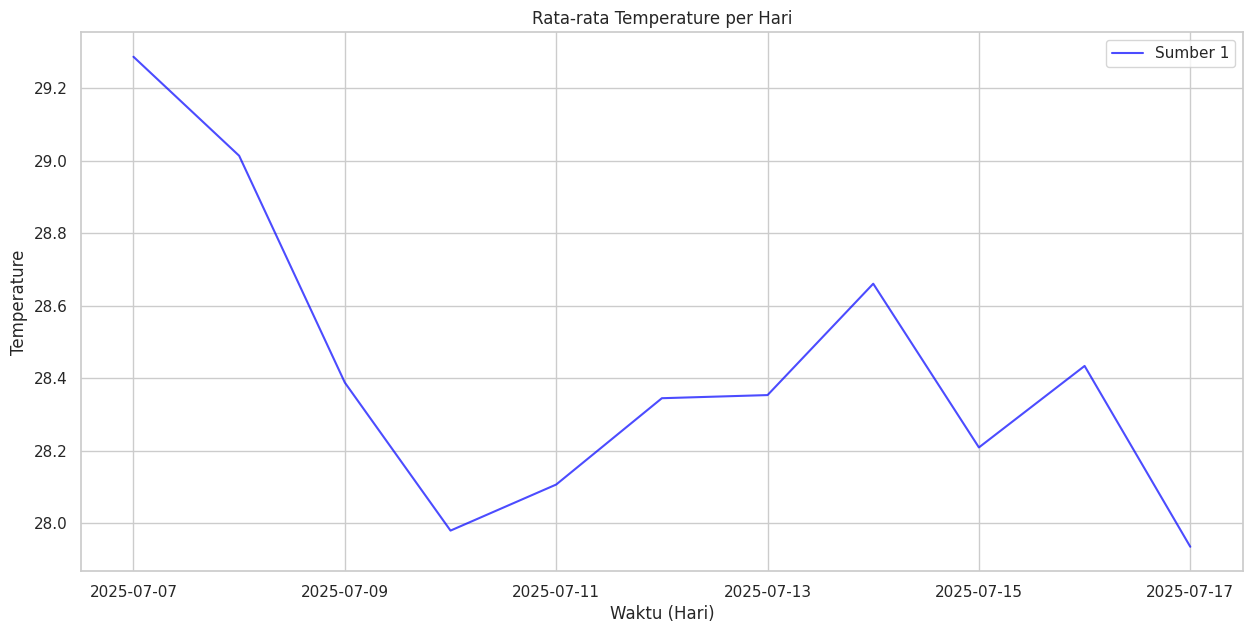

In [23]:
# Variabel pengganti untuk menentukan kolom yang akan digunakan
column_to_plot = 'temperature'  # Ubah ke 'humidity' atau 'pressure' sesuai kebutuhan

# Mengelompokkan data berdasarkan hari dan menghitung rata-rata untuk kolom yang dipilih
kumbung['day'] = kumbung['timestamp'].dt.floor('d')  # Membulatkan ke hari terdekat

# Menghitung rata-rata per hari untuk kolom yang dipilih
kumbung_daily = kumbung.groupby('day')[column_to_plot].mean().reset_index()

# Plot data dari kedua DataFrame
plt.figure(figsize=(15, 7))

# Plot data dari kumbung
plt.plot(kumbung_daily['day'], kumbung_daily[column_to_plot], label='Sumber 1', color='blue', alpha=0.7)

# Menambahkan label, judul, dan legenda
plt.xlabel('Waktu (Hari)')
plt.ylabel(f'{column_to_plot.capitalize()}')
plt.title(f'Rata-rata {column_to_plot.capitalize()} per Hari')
plt.legend()
plt.grid(True)

# Menampilkan plot
plt.show()

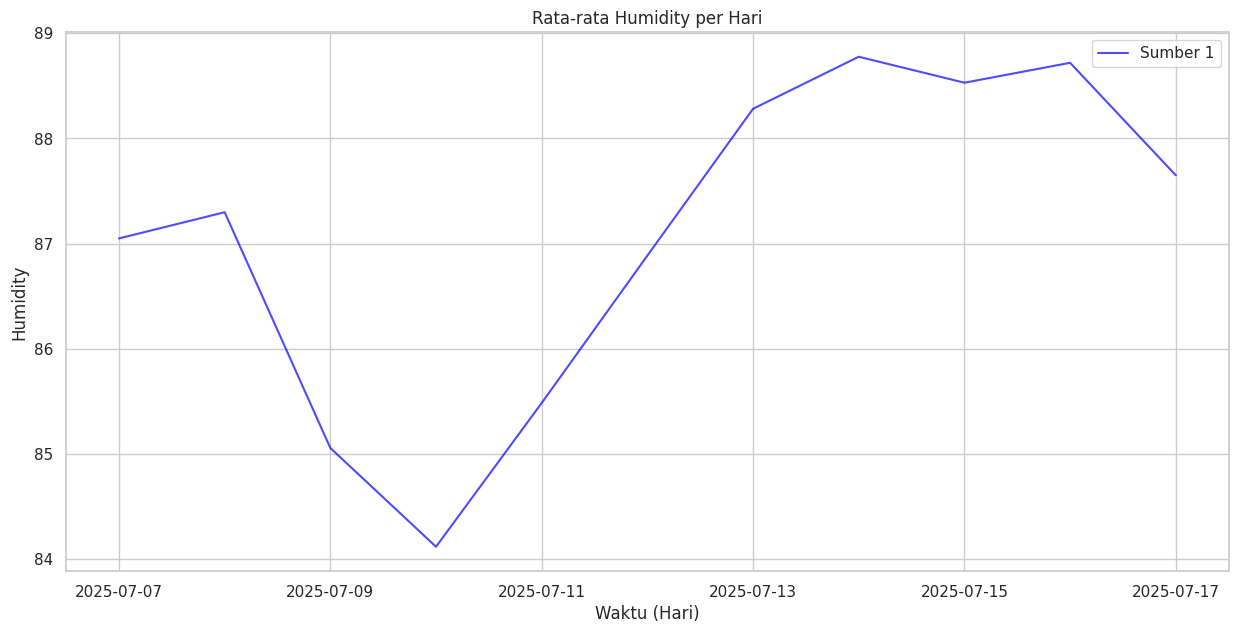

In [24]:
# Variabel pengganti untuk menentukan kolom yang akan digunakan
column_to_plot = 'humidity'  # Ubah ke 'humidity' atau 'pressure' sesuai kebutuhan

# Mengelompokkan data berdasarkan hari dan menghitung rata-rata untuk kolom yang dipilih
kumbung['day'] = kumbung['timestamp'].dt.floor('d')  # Membulatkan ke hari terdekat

# Menghitung rata-rata per hari untuk kolom yang dipilih
kumbung_daily = kumbung.groupby('day')[column_to_plot].mean().reset_index()

# Plot data dari kedua DataFrame
plt.figure(figsize=(15, 7))

# Plot data dari kumbung
plt.plot(kumbung_daily['day'], kumbung_daily[column_to_plot], label='Sumber 1', color='blue', alpha=0.7)

# Menambahkan label, judul, dan legenda
plt.xlabel('Waktu (Hari)')
plt.ylabel(f'{column_to_plot.capitalize()}')
plt.title(f'Rata-rata {column_to_plot.capitalize()} per Hari')
plt.legend()
plt.grid(True)

# Menampilkan plot
plt.show()

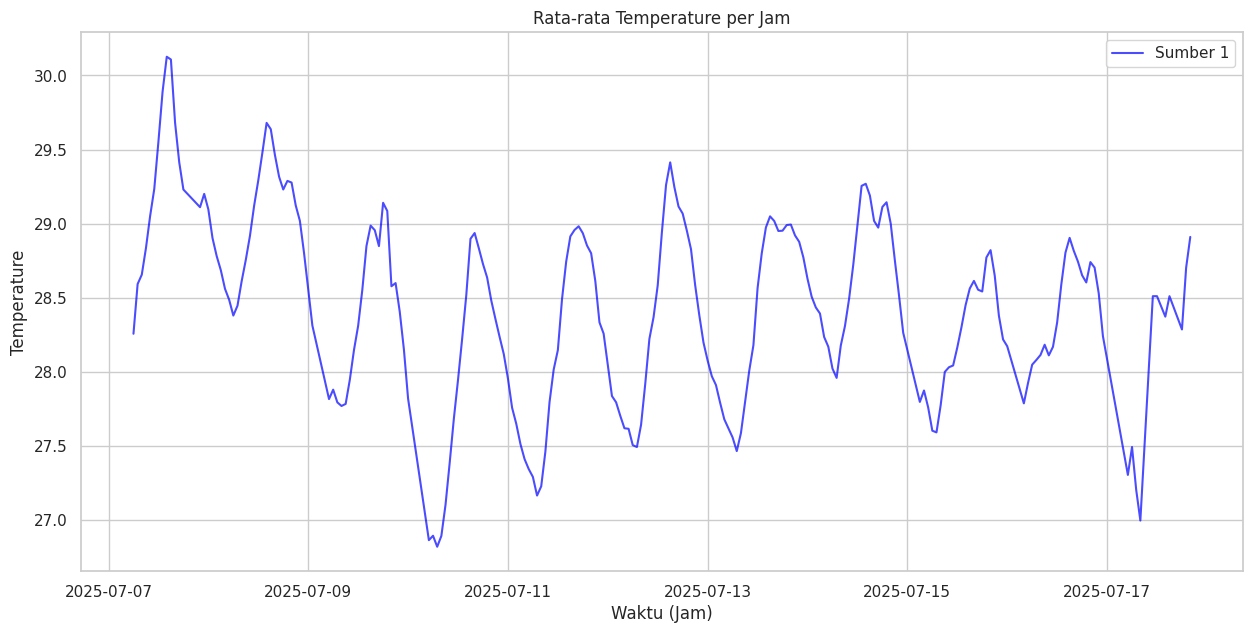

In [25]:
# Variabel pengganti untuk menentukan kolom yang akan digunakan
column_to_plot = 'temperature'  # Ubah ke 'humidity' atau 'pressure' sesuai kebutuhan

# Mengelompokkan data berdasarkan jam dan menghitung rata-rata
kumbung['hour'] = kumbung['timestamp'].dt.floor('h')  # Membulatkan ke jam terdekat

# Menghitung rata-rata per jam untuk kolom yang dipilih
kumbung_hourly = kumbung.groupby('hour')[column_to_plot].mean().reset_index()

# Plot data dari kedua DataFrame
plt.figure(figsize=(15, 7))

# Plot data dari kumbung
plt.plot(kumbung_hourly['hour'], kumbung_hourly[column_to_plot], label='Sumber 1', color='blue', alpha=0.7)

# Menambahkan label, judul, dan legenda
plt.xlabel('Waktu (Jam)')
plt.ylabel(f'{column_to_plot.capitalize()}')
plt.title(f'Rata-rata {column_to_plot.capitalize()} per Jam')
plt.legend()
plt.grid(True)

# Menampilkan plot
plt.show()

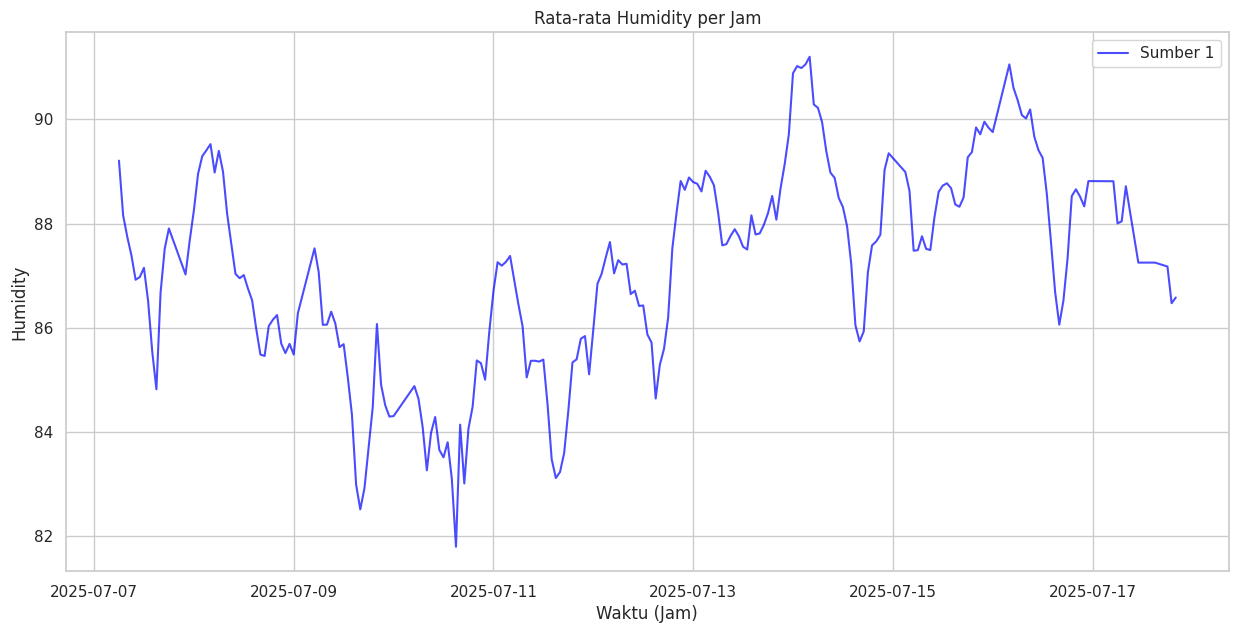

In [26]:
# Variabel pengganti untuk menentukan kolom yang akan digunakan
column_to_plot = 'humidity'  # Ubah ke 'humidity' atau 'pressure' sesuai kebutuhan

# Mengelompokkan data berdasarkan jam dan menghitung rata-rata
kumbung['hour'] = kumbung['timestamp'].dt.floor('h')  # Membulatkan ke jam terdekat

# Menghitung rata-rata per jam untuk kolom yang dipilih
kumbung_hourly = kumbung.groupby('hour')[column_to_plot].mean().reset_index()

# Plot data dari kedua DataFrame
plt.figure(figsize=(15, 7))

# Plot data dari kumbung
plt.plot(kumbung_hourly['hour'], kumbung_hourly[column_to_plot], label='Sumber 1', color='blue', alpha=0.7)

# Menambahkan label, judul, dan legenda
plt.xlabel('Waktu (Jam)')
plt.ylabel(f'{column_to_plot.capitalize()}')
plt.title(f'Rata-rata {column_to_plot.capitalize()} per Jam')
plt.legend()
plt.grid(True)

# Menampilkan plot
plt.show()

In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint

In [38]:
# Mengelompokkan data berdasarkan jam dan menghitung rata-rata variabel
kumbung_hourly_temp = kumbung.groupby('hour')['temperature'].mean().reset_index()

# Pastikan data sudah terurut berdasarkan waktu
kumbung_hourly_temp = kumbung_hourly.sort_values(by='hour').reset_index(drop=True)

# Menyiapkan data untuk model
def create_sequences(data, lookback, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - lookback - forecast_horizon):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback:i + lookback + forecast_horizon])
    return np.array(X), np.array(y)

In [40]:
kumbung_hourly_temp

,hour,humidity
0,2025-07-07 06:00:00+07:00,89.208625
1,2025-07-07 07:00:00+07:00,88.159417
2,2025-07-07 08:00:00+07:00,87.744034
3,2025-07-07 09:00:00+07:00,87.386387
4,2025-07-07 10:00:00+07:00,86.921083
...,...,...
224,2025-07-17 14:00:00+07:00,87.250000
225,2025-07-17 15:00:00+07:00,87.250000
226,2025-07-17 18:00:00+07:00,87.174737
227,2025-07-17 19:00:00+07:00,86.470420


In [34]:
# Mengelompokkan data berdasarkan jam dan menghitung rata-rata variabel
kumbung_hourly_humi = kumbung.groupby('hour')['humidity'].mean().reset_index()

# Pastikan data sudah terurut berdasarkan waktu
kumbung_hourly_humi = kumbung_hourly.sort_values(by='hour').reset_index(drop=True)

# Menyiapkan data untuk model
def create_sequences(data, lookback, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - lookback - forecast_horizon):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback:i + lookback + forecast_horizon])
    return np.array(X), np.array(y)

### Improve Model Architecture

To improve the model, we will make the following changes:
1.  **Increase `lookback` and `forecast_horizon`**: We will change the `lookback` from 24 to 72 (3 days) and `forecast_horizon` from 1 to 24 (1 day). This will allow the model to use 3 days of historical data to predict the next 24 hours of temperature.
2.  **Add Dropout Layers**: We will add `Dropout` layers to the LSTM model to prevent overfitting.
3.  **Add Model Checkpoint**: We will use `ModelCheckpoint` to save the best model during training.

In [35]:
from sklearn.preprocessing import MinMaxScaler

# Normalisasi data
scaler = MinMaxScaler()
temperature_scaled = scaler.fit_transform(kumbung_hourly_temp[['temperature']].values)

# Tentukan parameter lookback dan forecast horizon
lookback = 1
forecast_horizon = 6

# Membuat dataset
X, y = create_sequences(temperature_scaled, lookback, forecast_horizon)

KeyError: "None of [Index(['temperature'], dtype='object')] are in the [columns]"

In [ ]:
# Normalisasi data
scaler = MinMaxScaler()
humidity_scaled = scaler.fit_transform(kumbung_hourly_humi[['humidity']].values)

# Tentukan parameter lookback dan forecast horizon
lookback = 1
forecast_horizon = 6

# Membuat dataset
X, y = create_sequences(humidity_scaled, lookback, forecast_horizon)

In [ ]:
# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Membangun model TensorFlow
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(lookback, 1), return_sequences=True),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, activation='relu'),
    #tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(forecast_horizon),
])

In [ ]:
from keras.utils import plot_model
import pydot
import graphviz

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Mengatur optimizer dengan learning rate khusus
optimizer = Adam(learning_rate=0.001)  # Ubah nilai learning rate sesuai kebutuhan
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

In [ ]:
# Melatih model

# Definisikan EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

In [ ]:
# Membuat prediksi
predictions = model.predict(X_test)

# Membalikkan normalisasi untuk interpretasi hasil
# Reshape predictions dan y_test agar menjadi 2D sebelum inverse_transform
predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# Menampilkan hasil prediksi vs data aktual untuk langkah pertama (step 0 dari 6 jam ke depan)
plt.figure(figsize=(15, 5))
plt.plot(y_test_rescaled[:50, 0], label='Actual Temperature (Step 0)')
plt.plot(predictions_rescaled[:50, 0], label='Predicted Temperature (Step 0)')
plt.legend()
plt.title('Prediksi ke Depan (Step 0)')
plt.xlabel('Sample')
plt.ylabel('Temperature')
plt.show()
model.summary()

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Menguji Model dengan Data Baru
Selanjutnya, kita akan menguji model dengan data input baru untuk memprediksi suhu di jam-jam berikutnya. Kita akan menggunakan data terakhir dari dataset sebagai input.

In [ ]:
# Mengambil data terakhir dari dataset untuk pengujian
last_data = temperature_scaled[-lookback:]

# Mengubah bentuk data agar sesuai dengan input model
last_data = last_data.reshape(1, lookback, 1)

# Membuat prediksi
new_predictions = model.predict(last_data)

# Membalikkan normalisasi untuk mendapatkan nilai suhu aktual
new_predictions_rescaled = scaler.inverse_transform(new_predictions)

# Menampilkan hasil prediksi
print("Prediksi suhu :")
for i, temp in enumerate(new_predictions_rescaled[0]):
    print(f"Jam ke-{i+1}: {temp:.2f}°C")

# Visualisasi hasil prediksi
plt.figure(figsize=(10, 5))

# Plot data historis
plt.plot(kumbung_hourly['hour'], kumbung_hourly['temperature'], label='Data Historis', color='blue')

# Menyiapkan sumbu x untuk prediksi
last_hour = kumbung_hourly['hour'].iloc[-1]
prediction_hours = pd.to_datetime([last_hour + pd.DateOffset(hours=i) for i in range(1, forecast_horizon + 1)])

# Plot prediksi
plt.plot(prediction_hours, new_predictions_rescaled[0], label='Prediksi Suhu', color='red', marker='o')

plt.title('Prediksi Suhu')
plt.xlabel('Waktu')
plt.ylabel('Suhu (°C)')
plt.legend()
plt.grid(True)
plt.show()